<img src="https://www.unizar.es/sites/default/files/identidadCorporativa/imagen/logoUZ.png"  width="480">

# SELF-SIMILARITY LAG MATRIX CALCULATION
Coded by: Carlos Hernández, José Ramón Beltrán, David Díaz-Guerra

Department of Electronic Engineering and Communications, Universidad de Zaragoza, Calle María de Luna 3, 50018 Zaragoza


This notebook provides step by step the calculation of a self-similarity lag matrix according to the EUPSICO 2015 paper: "Boundary Detection in Music Structure Analysis using Convolutional Neural Networks." of T. Grill and J. Schlüter available in: http://www.ofai.at/~jan.schlueter/pubs/2015_eusipco.pdf

Self-Similarity matrices and self-similarity lag matrices are used in several studies of Music Information Retrieval (MIR) tasks such as Boundaries Detection or Labelling. Its clear representation of the homogeneous sections in music pieces make them a powerful tool in these studies.

Abbreviations: 
* MLS - mel-spectrogram
* SSLM -  self-similarity lag matrix



The first step is to import all the libraries that we need to run our code:

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure
import scipy
from scipy.spatial import distance

We import the song we want to process

In [2]:
song = "1358"
song_path = "/home/carlos/Documentos/" + song + ".mp3"

Now we set the parameter's values

In [3]:
"""====================Parameters===================="""
window_size = 2048 #(samples/frame)
hop_length = 1024 #overlap 50% (samples/frame) 
sr_desired = 44100
p = 2 #max-pooling factor
L_sec = 14 #lag context in seconds
L = round(L_sec*sr_desired/hop_length) #conversion of lag L seconds to frames

We need to be sure that the sampling frequency is set to 44100Hz, otherwise we resample the signal

In [4]:
y, sr = librosa.load(song_path, sr=None)

if sr != sr_desired:
    y = librosa.core.resample(y, sr, sr_desired)
    sr = sr_desired

/home/carlos/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


## Mel Spectrogram

With the help of librosa library we can compute the mel spectrogram of the audio file with the following parameters:

* 80 mel-filter banks
* frequency from 80 to 16000Hz.


In [5]:
"""=================Mel Spectrogram================"""
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=window_size, hop_length=hop_length, n_mels=80, fmin=80, fmax=16000)
S_to_dB = librosa.power_to_db(S,ref=np.max) #convert the spectrogram in dB   

We can plot the Mel Spectrogram (MLS):

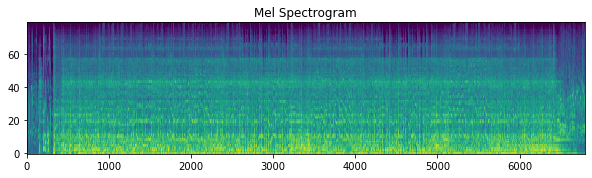

MLS dimensions are: [mel bands, N]
MLS dimensions are: [ 80 , 6796 ]


In [6]:
#Plot MLS
plt.figure(figsize=(10, 4))
plt.title("Mel Spectrogram")
fig = plt.imshow(S_to_dB,origin='lower', cmap='viridis', aspect=20)
plt.show()
print("MLS dimensions are: [mel bands, N]")
print("MLS dimensions are: [", S_to_dB.shape[0], ",", S_to_dB.shape[1],"]")

## Self-Similarity Lag Matrix

We pad the *L* lag time frames to the beginning of the mel spectrogram as it shows the following equation:

\begin{equation} \label{pad}
\check{x}_i = \mathrm{concat}_i(\Phi_i, x_i)
\end{equation}

In [7]:
padding_factor = L  #frames 
pad = np.full((S_to_dB.shape[0], padding_factor), -70) #matrix of 80x30frames of -70dB corresponding to padding
S_padded = np.concatenate((pad, S_to_dB), axis=1) #padding 30 frames with noise at -70dB at the beginning

We can plot the S_padded $(\check{x}_i)$:

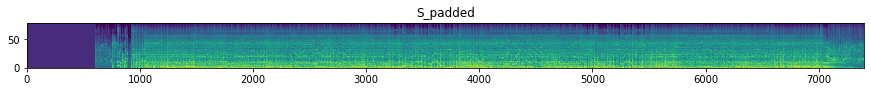

S_padded dimensions are: [mel bands, N+L] (with Lin frames)
S_padded dimensions are: [ 80 , 7399 ]


In [8]:
#Plot S_padded
plt.figure(figsize=(15, 15))
plt.title("S_padded")
fig = plt.imshow(S_padded,origin='lower', cmap='viridis', aspect=5)
plt.show()
print("S_padded dimensions are: [mel bands, N+L] (with Lin frames)")
print("S_padded dimensions are: [", S_padded.shape[0], ",", S_padded.shape[1],"]")

Then, a max-pool of a factor of $p_1$ is done in the time dimension as the following equation shows.

\begin{equation} \label{max_pool}
x_i^\prime = \mathrm{max}_{j=1...p}(\check{x}_{(i-1)p+j})
\end{equation}

In [9]:
x_prime = skimage.measure.block_reduce(S_padded, (1,p), np.max) #Mel Spectrogram downsampled

If we plot x_prime which is equal to $(\check{x}_i)$ max-pooled in time dimension (columns) and we plot it with the same scale we get:

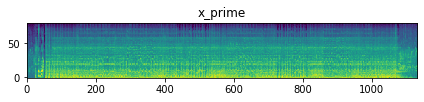

x_prime dimensions are: [mel bands, (N+L)/p] (with L in frames)
x_prime dimensions are: [ 80 , 1133 ]


In [47]:
#Plot x_prime
plt.figure(figsize=(7, 7))
plt.title("x_prime")
fig = plt.imshow(x_prime,origin='lower', cmap='viridis', aspect=2)
plt.show()
print("x_prime dimensions are: [mel bands, (N+L)/p] (with L in frames)")
print("x_prime dimensions are: [", x_prime.shape[0], ",", x_prime.shape[1],"]")

After that, we apply a Discrete Cosine Transform of Type II (DCT) of each frame ommiting the first element.

\begin{equation} \label{DCT}
\tilde{x}_i = \mathrm{DCT}_{1...n}^{\mathrm{(II)}}(x_i^\prime)
\end{equation}

In [11]:
#MFCCs calculation by computing the Discrete Cosine Transform of type II (DCT-II)
MFCCs = scipy.fftpack.dct(x_prime, axis=0, type=2, norm='ortho')
MFCCs = MFCCs[1:,:]

By plotting the MFCCs we get:

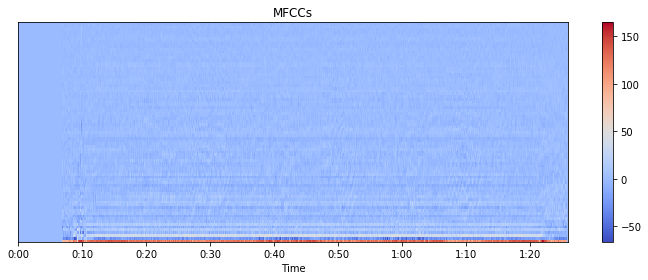

MFCCs dimensions are: [mel bands - 1, (N+L)/p] (with L in frames)
MFCCs dimensions are: [ 79 , 3700 ]


In [12]:
#Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(MFCCs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()
print("MFCCs dimensions are: [mel bands - 1, (N+L)/p] (with L in frames)")
print("MFCCs dimensions are: [", MFCCs.shape[0], ",", MFCCs.shape[1],"]")

Now we stacked by a factor $\textit{m}$ the time frames so we obtain the time series in the following equation.

\begin{equation} \label{3}
\hat{x}_i = [\tilde{x}_i^\mathrm{T},...,\tilde{x}_{i+m}^\mathrm{T}]
\end{equation}

In [13]:
#Bagging frames
m = 2 #baggin parameter in frames
x = [np.roll(MFCCs,n,axis=1) for n in range(m)]
x_hat = np.concatenate(x, axis=0)

And now we can plot the x_hat variable:

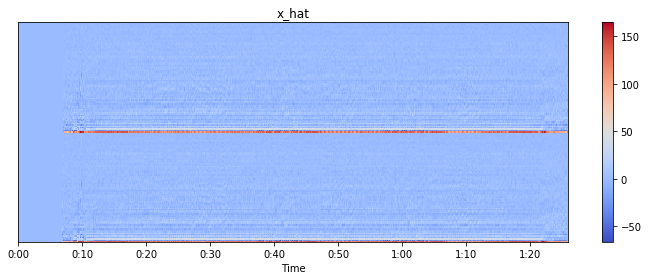

x_hat dimensions are: [(mel bands - 1)*m, (N+L)/p] (with L in frames)
x_hat dimensions are: [ 158 , 3700 ]


In [28]:
#Plot x_hat
plt.figure(figsize=(10, 4))
librosa.display.specshow(x_hat, x_axis='time')
plt.colorbar()
plt.title('x_hat')
plt.tight_layout()
plt.show()
print("x_hat dimensions are: [(mel bands - 1)*m, (N+L)/p] (with L in frames)")
print("x_hat dimensions are: [", x_hat.shape[0], ",", x_hat.shape[1],"]")

The next step is computing the distance between vectors of the time series $\hat{x}_i$. The distance metric used in this notebook will be the cosine distance which is used in the literature.

\begin{equation} \label{distance_cos}
\mathrm{\delta_{cos} = 1 -} \frac{u.v}{\|u\|.\|v\|}
\end{equation}

where *u* and *v* are 2 vectors of the time series corresponding to $\hat{x}_i$ and $\hat{x}_{i-l}$.

\begin{equation} \label{4}
D_{i,l} = \delta(\tilde{x}_i,\tilde{x}_{i-l}), \quad l = 1...\left[\frac{L}{p}\right]
\end{equation}

In [15]:
#Cosine distance calculation: D[N/p,L/p] matrix
distances = np.zeros((x_hat.shape[1], padding_factor//p)) #D has as dimensions N/p and L/p
for i in range(x_hat.shape[1]): #iteration in columns of x_hat
    for l in range(padding_factor//p):
        if i-(l+1) < 0:
            cosine_dist = 1
        elif i-(l+1) < padding_factor//p:
            cosine_dist = 1
        else:
            cosine_dist = distance.cosine(x_hat[:,i], x_hat[:,i-(l+1)]) #cosine distance between columns i and i-L
        distances[i,l] = cosine_dist

We can plot the distances matrix obtained:

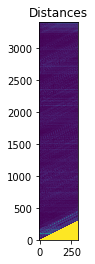

Distance matrix dimensions are: [N/p, L/p] (with L in frames)
Distance matrix dimensions are: [ 3399 , 301 ]


In [37]:
#Plot Distances
plt.figure(figsize=(10, 4))
plt.title("Distances")
fig = plt.imshow(distances,origin='lower', cmap='viridis', aspect=0.5)
plt.show()
print("Distance matrix dimensions are: [N/p, L/p] (with L in frames)")
print("Distance matrix dimensions are: [", distances.shape[0], ",", distances.shape[1],"]")

Then, it has to be computed an equalization factor $\varepsilon_{i,l}$ with a quantile $\kappa$ of the distances $\delta(\tilde{x}_i,\tilde{x}_{i-j})$ for $j = \mathrm{1}...\left[\frac{L}{p}\right]$

\begin{equation} \label{epsilon}
\varepsilon_{i,l} = Q_\kappa(D_{i,l},...,D_{i,[\frac{L}{p}]},D_{i-l,1},...,D_{i-l,[\frac{L}{p}]})
\end{equation}

In [17]:
#Threshold epsilon[N/p,L/p] calculation
kappa = 0.1 #equalization factor of 10%
epsilon = np.zeros((distances.shape[0], padding_factor//p)) #D has as dimensions N/p and L/p
for i in range(padding_factor//p, distances.shape[0]): #iteration in columns of x_hat
    for l in range(padding_factor//p):
        epsilon[i,l] = np.quantile(np.concatenate((distances[i-l,:], distances[i,:])), kappa)

We plotepsilon matrix:

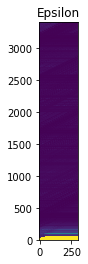

Epsilon matrix dimensions are: [N/p, L/p] (with L in frames)
Epsilon matrix dimensions are: [ 3399 , 301 ]


In [38]:
#Plot Epsilon
plt.figure(figsize=(10, 4))
plt.title("Epsilon")
fig = plt.imshow(epsilon,origin='lower', cmap='viridis', aspect=0.5)
plt.show()
print("Epsilon matrix dimensions are: [N/p, L/p] (with L in frames)")
print("Epsilon matrix dimensions are: [", epsilon.shape[0], ",", epsilon.shape[1],"]")

Now it's time to remove *L/p* lag bins in time dimension at the beginning of the distances vector $D_{i,l}$ and in the equalization factor vector $\varepsilon_{i,l}$.

In [19]:
#Removing initial padding now taking into account the max-poolin factor
distances = distances[padding_factor//p:,:]  
epsilon = epsilon[padding_factor//p:,:] 
x_prime = x_prime[:,padding_factor//p:] 

Now that we have the SSLM calculated we just have to apply an transfer function $\sigma$.

\begin{equation} \label{R}
R_{i,l} = \sigma\left(\mathrm{1}-\frac{D_{i,l}}{\varepsilon_{i,l}}\right)
\end{equation}

where $\sigma(x) = \frac{1}{1+e^{-x}}$

In [20]:
#Self Similarity Lag Matrix
sslm = scipy.special.expit(1-distances/epsilon) #aplicación de la sigmoide
sslm = np.transpose(sslm)

The resulting SSLM is:

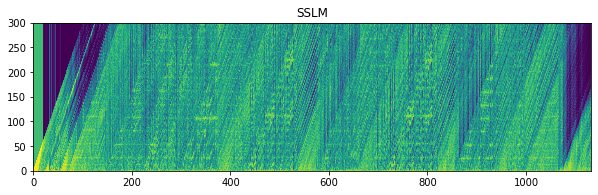

SSLM dimensions are: [L/p, N/(p*p_2)] (with L in frames an p_2 = 3)
SSLM  dimensions are: [ 301 , 1133 ]


In [41]:
#Plot Epsilon
plt.figure(figsize=(10, 4))
plt.title("SSLM")
fig = plt.imshow(sslm, origin='lower', cmap='viridis')
plt.show()
print("SSLM dimensions are: [L/p, N/(p*p_2)] (with L in frames an p_2 = 3)")
print("SSLM  dimensions are: [", sslm.shape[0], ",", sslm.shape[1],"]")

Now, in order to reduce dimensions to make the SSLMs smaller for the future Neural Network which will take them as inputs, we max-pool by a new factor of $p_2$ = 3 to obtain the final SSLM and the MLS

In [22]:
sslm = skimage.measure.block_reduce(sslm, (1,3), np.max)
x_prime = skimage.measure.block_reduce(x_prime, (1,3), np.max)

/home/carlos/anaconda3/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


We can check if the resulting SSLM has "nans" due to the cosine distance computation, and if it has them, we removed them by zero:

In [23]:
#Check if SSLM has nans and if it has them, substitute them by 0
for i in range(sslm.shape[0]):
    for j in range(sslm.shape[1]):
        if np.isnan(sslm[i,j]):
            sslm[i,j] = 0

And now we can plot the final MLS and SSLM:

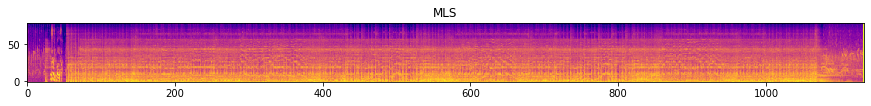

In [24]:
#Plot Mel Spectrogram
plt.figure(1, figsize=(15, 15))
plt.title("MLS")

plt.imshow(x_prime,origin='lower', cmap='plasma')
plt.show()

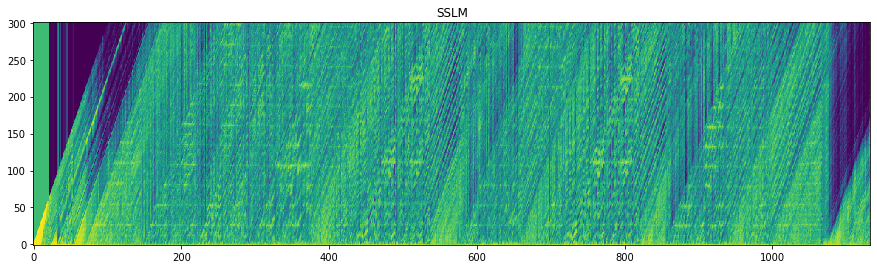

In [25]:
#Plot SSLM
plt.figure(2, figsize=(15, 15))
plt.title("SSLM")
fig = plt.imshow(sslm,origin='lower', cmap='viridis')
plt.show()

To finish with, we can check if MLS and SSLM have the same time frames (compulsory if we want to introduce them in a NN as inputs

In [26]:
if sslm.shape[1] == x_prime.shape[1]:
    print("SSLM and MLS have the same time dimension (columns).")
else:
    print("ERROR. Time dimension of SSLM and MLS mismatch.")
    print("MLS has", x_prime.shape[1], "lag bins and the SSLM", sslm.shape[1])

SSLM and MLS have the same time dimension (columns).
